In [5]:
import pandas as pd
import numpy as np
import os
import datetime
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats
from google.cloud import bigquery
from google.oauth2 import service_account
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.style.use('ggplot')
import json
from matplotlib.lines import Line2D

In [3]:
################ MODEL RELATED

import numpy as np 

import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import os
import pandas as pd

# from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from google.cloud import bigquery
from google.oauth2 import service_account
import datetime

import warnings
warnings.filterwarnings("ignore")

# path = r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Raycon'
# os.chdir(path)
path = os.getcwd()

from Source.inception import InceptionBlock

class Flatten(nn.Module):
    def __init__(self, out_features):
        super(Flatten, self).__init__()
        self.output_dim = out_features

    def forward(self, x):
        return x.view(-1, self.output_dim)
    
class Reshape(nn.Module):
    def __init__(self, out_shape):
        super(Reshape, self).__init__()
        self.out_shape = out_shape

    def forward(self, x):
        return x.view(-1, *self.out_shape)
    
#### Make Model
LOOK_BACK = 15
model= nn.Sequential(
                    Reshape(out_shape=(5,LOOK_BACK)),
                    InceptionBlock(
                        in_channels=5, 
                        n_filters=32, 
                        kernel_sizes=[5,13,23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5,13,23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveMaxPool1d(output_size=1),
#     nn.AdaptiveMaxPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=3)
        )
model.load_state_dict(torch.load(path+'\Source\Inception_time.pth', map_location=torch.device('cpu')))
model.eval()



Sequential(
  (0): Reshape()
  (1): InceptionBlock(
    (activation): ReLU()
    (inception_1): Inception(
      (bottleneck): Conv1d(5, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(32, 32, kernel_size=(13,), stride=(1,), padding=(6,), bias=False)
      (conv_from_bottleneck_3): Conv1d(32, 32, kernel_size=(23,), stride=(1,), padding=(11,), bias=False)
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (conv_from_maxpool): Conv1d(5, 32, kernel_size=(1,), stride=(1,), bias=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (inception_2): Inception(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), pad

In [8]:
def getdata():
    credentials = service_account.Credentials.from_service_account_file(path+'\\Source\\Config\\bigqueryauth.json')
    project_id = 'solar-222307'
    client = bigquery.Client(credentials= credentials,project=project_id)
    
    os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Raycon\Raycon Data')
    raycon_data=pd.read_pickle('raycon_data.pkl')
    raycon_data['logged_on_utc']=pd.to_datetime(raycon_data['logged_on_utc'])
    last_timestamp=raycon_data.sort_values('logged_on_utc')['logged_on_utc'].iloc[-1]
#     last_timestamp = '2011-10-10'

    query_job=client.query('select * from dev_loggers.raycon where logged_on_utc>"{}"'.format(last_timestamp))
    results = query_job.result().to_dataframe()
    results = results.dropna(subset=['logged_on_utc'])
#     raycon_data=results
    raycon_data['logged_on_utc']=pd.to_datetime(raycon_data['logged_on_utc'])
    raycon_data=raycon_data.append(results)
    raycon_data.to_pickle('raycon_data.pkl')
    raycon_data=raycon_data.reset_index()
    return raycon_data


def getmetadata(pivot_data,device_map):
    device_map1=device_map[['tuya_id','name']].set_index('tuya_id').to_dict()['name']
    device_map2=device_map[['tuya_id','mean_power_consumption']].set_index('tuya_id').to_dict()['mean_power_consumption']
    device_map3=device_map[['tuya_id','consumption_category']].set_index('tuya_id').to_dict()['consumption_category']
    device_map4=device_map[['tuya_id','type']].set_index('tuya_id').to_dict()['type']
    pivot_data['name']=pivot_data['device_id'].map(device_map1)
    pivot_data['device_mean_consumption']=pivot_data['device_id'].map(device_map2)
    pivot_data['consumption_category']=pivot_data['device_id'].map(device_map3)
    pivot_data['type']=pivot_data['device_id'].map(device_map4)
    return pivot_data


def getfeatures(stdate,enddate,data, historical_data):
    
    ### When calling from loop
    if 'other' in data.columns:
        temp = pd.DataFrame(json.loads(historical_data))
        temp['logged_time_local'] = [datetime.datetime.fromtimestamp(timestamp/1000)+datetime.timedelta(hours=5.5) for timestamp in temp['logged_on_utc']]
        temp['mains_power']=(temp['active_power_P1']+temp['active_power_P2']+temp['active_power_P3'])/1000
        if len(temp) > 0:
            df = temp[['logged_time_local', 'mains_power']]
            df = temp.append(data[['logged_time_local', 'mains_power']])
        else:
            df = sample_data[['logged_time_local', 'mains_power']]
        n = len(temp)

    else:
        sample_data=data[(data['logged_on_utc']>=pd.to_datetime(stdate)-datetime.timedelta(hours=5.5)) & (data['logged_on_utc']<=pd.to_datetime(enddate)-datetime.timedelta(hours=5.5))].sort_values('logged_on_utc')
        df = pd.DataFrame(columns=sample_data.columns)
        df = df.append(pd.DataFrame(json.loads(historical_data)))
        n=len(df)
        #### Time change in pipeline
        df['logged_time_local'] = [datetime.datetime.fromtimestamp(timestamp/1000)+datetime.timedelta(hours=5.5) for timestamp in df['logged_on_utc']]
        sample_data['logged_time_local'] = [pd.to_datetime(timestamp)+datetime.timedelta(hours=5.5) for timestamp in sample_data['logged_on_utc']]
        sample_data = sample_data.sort_values('logged_time_local').drop_duplicates('logged_time_local').set_index('logged_time_local').resample('50ms').interpolate().reset_index()
        df = df.append(sample_data)
        df['mains_power']=(df['active_power_P1']+df['active_power_P2']+df['active_power_P3'])/1000
    #         print(df)
    frequency=20
    mean_step=30
    factor=10
    #     sample_data=df
    ### Processing
    df['before_mean']=df['mains_power'].rolling(mean_step).mean()
    df['before_max_10']=df['mains_power'].abs().rolling(mean_step*factor).max()
    df['before_mean_10']=df['mains_power'].abs().rolling(mean_step*factor).mean()
    df['after_mean']=0
    df['after_mean_10']=0
    df['after_max_10']=0
    df['per_change']=0
    df['time_spent']=0

    # Features
    per_change=[]
    after_mean=[]
    after_mean_10=[]
    after_max=[]

    for i in range(mean_step,len(df)-mean_step):
        change=100*(df['before_mean'].iloc[i+mean_step]-df['before_mean'].iloc[i-1])/df['before_mean'].iloc[i+mean_step]
        per_change.append(change)
        after_mean.append(df['before_mean'].iloc[i+mean_step])

    for i in range(mean_step*factor,len(df)-mean_step*factor-3):
        after_mean_10.append(df['before_mean_10'].iloc[i+3+mean_step*factor])
        after_max.append(df['before_max_10'].iloc[i+3+mean_step*factor])

    df['per_change'].iloc[mean_step:-mean_step]=per_change
    df['after_mean'].iloc[mean_step:-mean_step]=after_mean
    df['after_mean_10'].iloc[mean_step*factor:-mean_step*factor-3]=after_mean_10
    df['after_max_10'].iloc[mean_step*factor:-mean_step*factor-3]=after_max
    df['avg_diff']=df['after_mean']-df['before_mean']
    df['avg_diff']=df['after_mean']-df['before_mean']

    #event logic
    df['events']=0
    df.loc[(abs(df['avg_diff'])>.015) & (df['mains_power']<.10), 'events']=1
    df.loc[(abs(df['per_change'])>10) & (df['mains_power']>.10), 'events']=1
    df=df
    df['event_type']=0
    
    #event smoothening
    df['event_smoothening'] = df['events'].rolling(int(factor/2)).mean()
    df['events'] = [1 if i>.5 else 0 for i in df['event_smoothening']]
    
    #### transition start=1, transition= 2, transition end=3, steady=0
    df.loc[df['events']==True,'event_type']=2
    df.loc[df['events']==False,'event_type']=0

    #### map transition states
    df['event_effect']=0
    prev_state=0
    event_mean_before=0
    for i in range(1,len(df)):
        if df['events'].iloc[i]==0:
            if prev_state==1:
                df['event_type'].iloc[i-1]=3
            prev_state=0
        else:
            if prev_state==0:
                df['event_type'].iloc[i]=1
            prev_state=1
            
    
    #### Observable events for on/off activity
    df['observable_event']=0
    df['event_effect']=0
    for i in range(len(df)):
        if df['event_type'].iloc[i]==1:
            after=0
            j=i+5*frequency
            for j in range(i+5*frequency,min(i+5*frequency+mean_step*factor,len(df)-1)):
                if (df['event_type'].iloc[j] != 1):
                    after=after +   df['mains_power'].iloc[j]
                else:
                    break
            after=after/(j-(i+5*frequency-1))
            before=0
            k=i-3*frequency
            for k in range(i-3*frequency,max(i-3*frequency-mean_step*factor,0),-1):
                if (df['event_type'].iloc[k] != 1):
                    before=before +   df['mains_power'].iloc[k]
                else:
                    break
            before=before/(i-(k+3*frequency-1))
            df['event_effect'].iloc[i]=after-before


    df.loc[(abs(df['event_effect'])>.010),'observable_event']=1
    df.loc[(df['event_effect']<0) & (df['observable_event']==1),'observable_event']=2
#     print(df)
#     print(df.iloc[n:,:])
    
    df['model_data'] = pd.concat([df.mains_power.shift(i) for i in range(10)], 1).fillna(0).values.tolist()
    return df.iloc[n:,:]

# def classify_appliance(appliances,power,device_map):
#     if appliances=='all':
#         return device_map['name'].iloc[(device_map['mean_power_consumption']-power).abs().argsort()[:1]].values[0]
#     else:
#         if len(device_map.loc[device_map['name'].isin(appliances)])==0:
#             return 0
#         else:
#             return device_map.loc[device_map['name'].isin(appliances),'name'].iloc[(device_map.loc[device_map['name'].isin(appliances), 'mean_power_consumption']-abs(power)).abs().argsort()[:1]].values[0]

def classify_appliance(appliances,power,device_map,category=True):
    
#     if global_equipment.training_available:
#         model.load()
#         model.predict(power)
        
#     else:
    if appliances=='all':
        return device_map['name'].iloc[(device_map['mean_power_consumption']-power).abs().argsort()[:1]].values[0]
    else:
        if len(device_map.loc[(device_map['name'].isin(appliances)) & (device_map['consumption_category']==category)])==0:
            return 0
        else:
            return device_map.loc[(device_map['name'].isin(appliances)) & (device_map['consumption_category']==category),'name'].iloc[(device_map.loc[(device_map['name'].isin(appliances)) & (device_map['consumption_category']==category), 'mean_power_consumption']-abs(power)).abs().argsort()[:1]].values[0]


# def estimated_usage(std,endd,appliance,device_map):
#     return device_map.loc[device_map['name']==appliance, 'mean_power_consumption']*(endd-std).seconds/3600

def getoutput(stdate,enddate,temp_data,device_map,historical_json):

    event_df=pd.DataFrame(columns=['start_on_local','end_on_local','avg_mains_power','equipment_name','status','energy_consumption','event_on_local','event_off_local'])
    ind=1
    prev_avg_mains_power=.2
    active_names={}
    active_names['other']=stdate
#     main_temp=pd.DataFrame()
#     appliance_list=[]
#     event_df=pd.DataFrame(columns=['start_on_local','end_on_local','avg_mains_power','name','status','energy_consumption','event_on_local','event_off_local'])
    main_temp=pd.DataFrame()
    appliance_list=[]
    for start,end in zip(pd.date_range(stdate,enddate, freq='5min')[:-1],pd.date_range(stdate,enddate, freq='5min')[1:]):
        print(start)
        event_df_temp=pd.DataFrame(columns=['start_on_local','end_on_local','avg_mains_power','name','status','energy_consumption','event_on_local','event_off_local'])
        temp=temp_data.set_index('logged_time_local')
        temp=temp[(temp.index<=end) & (temp.index>=start)]
        event_df_temp.loc[ind]=[start,end,None,'all','NA',temp['mains_power'].sum()/3600,None,None]
        temp['active_appliances']=None
        for name in active_names.keys():
            ind=ind+1
            event_df_temp.loc[ind,'name']=name
            event_df_temp.loc[event_df_temp['name']==name,'event_on_local']=str(start)
            event_df_temp.loc[event_df_temp['name']==name,'status']='active'
        
        event_df_temp.loc[event_df_temp['name']=='other']=[start,end,prev_avg_mains_power,'other','NA',0,str(start),str(end)]
        for i in range(len(temp)):
            temp['active_appliances'].iloc[i]=list(active_names)
            if temp['observable_event'].iloc[i]==1:

 

                name=classify_appliance('all',abs(temp['event_effect'].iloc[i]),device_map)
                if name in event_df_temp['name'].unique():
                    if name in active_names.keys():
                        continue
                    else:
                        active_names[name]=str(temp.index[i])
                        event_df_temp.loc[event_df_temp['name']==name,'status']='active'
                        event_df_temp.loc[event_df_temp['name']==name,'event_on_local']=str(event_df_temp.loc[event_df_temp['name']==name,'event_on_local'].values[0])+' '+str(temp.index[i])
                else:
                    ind=ind+1
                    event_df_temp.loc[ind,'event_on_local']=str(temp.index[i])
                    event_df_temp.loc[ind,'name']=name
                    event_df_temp.loc[ind,'status']='active'
                    active_names[name]=str(temp.index[i])

 

            elif temp['observable_event'].iloc[i]==2:
                category= ['high' if v > 1 else 'low' if v <= .01 else 'medium' for v in [abs(temp['event_effect'].iloc[i])]][0]
                name=classify_appliance(active_names.keys(),abs(temp['event_effect'].iloc[i]),device_map,category)
                if name==0:
                    continue
                if  len(event_df_temp.loc[event_df_temp['name']==name,'event_off_local'].dropna())==0:
                    event_df_temp.loc[event_df_temp['name']==name,'event_off_local']=str(temp.index[i])
                else:
                    event_df_temp.loc[event_df_temp['name']==name,'event_off_local']=str(event_df_temp.loc[event_df_temp['name']==name,'event_off_local'].values[0])+','+str(temp.index[i])
                event_df_temp.loc[event_df_temp['name']==name,'status']='off'
                del active_names[name]
            else:
                continue

 

        for name in active_names.keys():
            if name=='other':
                continue
            if len(event_df_temp.loc[event_df_temp['name']==name,'event_off_local'].dropna())==0:
                event_df_temp.loc[event_df_temp['name']==name,'event_off_local']=str(temp.index[i])
            else:
                event_df_temp.loc[event_df_temp['name']==name,'event_off_local']=str(event_df_temp.loc[event_df_temp['name']==name,'event_off_local'].values[0])+','+str(temp.index[i])
        event_df_temp['start_on_local']=start
        event_df_temp['end_on_local']=end
        
        for iterator in range(3):
            if iterator==0:
                per_second_energy,energy_dict=energy_estimation(temp,prev_avg_mains_power)
            else:
                per_second_energy,energy_dict=energy_estimation(sample_df,prev_avg_mains_power)
#             print(temp)
            per_second_energy['mains_power']=per_second_energy['other']
            
            for equip in list(energy_dict):
                if equip=='other':
                    continue
                else:
                    event_df_temp.loc[event_df_temp['name']==equip,'energy_consumption']=event_df_temp.loc[event_df_temp['name']==equip,'energy_consumption'].fillna(0)+energy_dict[equip]/3600
#             print(per_second_energy)
            sample_df=getfeatures(stdate,enddate,per_second_energy,historical_json) 
#             print(sample_df)
            sample_df=sample_df.set_index('logged_time_local')
            sample_df['active_appliances']=temp['active_appliances']
        
        event_df_temp.loc[event_df_temp['name']=='other','energy_consumption']=energy_dict['other']/3600
        prev_avg_mains_power=energy_dict['other']/3600
        event_df=event_df.append(event_df_temp)
        main_temp=main_temp.append(temp)

 

    device_map1=device_map[['name','tuya_id']].set_index('name').to_dict()['tuya_id']
    device_map2=device_map[['name','room']].set_index('name').to_dict()['room']
    device_map3=device_map[['name','consumption_category']].set_index('name').to_dict()['consumption_category']
    device_map4=device_map[['name','phase']].set_index('name').to_dict()['phase']
    device_map5=device_map[['name','type']].set_index('name').to_dict()['type']
    event_df['tuya_id']=event_df['name'].map(device_map1)
    event_df['room']=event_df['name'].map(device_map2)
    event_df['consumption_category']=event_df['name'].map(device_map3)
    event_df['phase']=event_df['name'].map(device_map4)
    event_df['type']=event_df['name'].map(device_map5)
    event_df.loc[event_df['name']=='other','consumption_category']=event_df.loc[event_df['name']!='all','consumption_category'].fillna('other')
    event_df.loc[event_df['name']=='other','type']='other'    
    return main_temp,event_df

def energy_estimation(temp,other_original):
#     temp=temp[['mains_power','active_appliances']]

# def energy_estimation(temp)
    energy_dict={l:0 for l in list({x for l in list(temp.active_appliances) for x in l})}
    prev_energy_dict={}
#     other_original=0.088
    energy_dict={l:0 for l in list({x for l in list(temp.active_appliances) for x in l})}
    per_second_energy=[]
    ind=0
    df=pd.DataFrame(columns=energy_dict.keys())

    for i in range(len(temp)):
        prev_energy_dict['other']=other_original

        ### Distribution of Energy between Appliances
        if len(prev_energy_dict)==len(temp.active_appliances.iloc[i]):
            prev_energy_dict[list(prev_energy_dict.keys())[-1]]=temp.mains_power.iloc[i]-sum(list(prev_energy_dict.values())[0:-1])

        ### New Appliance is Active
        elif len(prev_energy_dict)<len(temp.active_appliances.iloc[i]):
            new_appliance=list((set(temp.active_appliances.iloc[i]) - set(prev_energy_dict)))[0]
            prev_energy_dict[new_appliance]=temp.mains_power.iloc[i]-sum(prev_energy_dict.values())

        ### One of the Appliances Deactives
        else:
            removed_appliance=list((set(prev_energy_dict)- set(temp.active_appliances.iloc[i])))[0]
            del prev_energy_dict[removed_appliance]
            prev_energy_dict[list(prev_energy_dict.keys())[-1]]=temp.mains_power.iloc[i]-sum(list(prev_energy_dict.values())[0:-1])

        ### Case When Calculated Equipment Usage > 1.5*Mean Consumption 
        excess=0
        negative_energy=[]
        for equipment in prev_energy_dict.keys():
            if equipment=='other':
                continue
            else:
                equipment_energy=prev_energy_dict[equipment]
                if equipment_energy>0:
                    prev_energy_dict[equipment]=min(equipment_energy,device_map.loc[device_map['name']==equipment,'mean_power_consumption'].values[0]*1.5)
                    excess=excess+equipment_energy-min(equipment_energy,device_map.loc[device_map['name']==equipment,'mean_power_consumption'].values[0]*1.5)
                else:
                    negative_energy.append(equipment)

        ### Remove Appliance if Calculated energy of appliance is negative
        for negative_equipment in negative_energy:
            del prev_energy_dict[negative_equipment]

        ### Add Excessive Energy to other
        other_original=prev_energy_dict['other']
        prev_energy_dict['other']=prev_energy_dict['other']+excess

        ### Check if Sum of all Appliance Energy> Original, if yes remove from original and subsequent appliances
        for appliance_excess in list(prev_energy_dict):
            if (sum(prev_energy_dict.values())-temp.mains_power.iloc[i])<=.015:
                break
            else:
                if appliance_excess=='other':
                    prev_energy_dict[appliance_excess]=max(.015,temp.mains_power.iloc[i]-sum(prev_energy_dict.values()))
                else:
                    prev_energy_dict[appliance_excess]=max(0,temp.mains_power.iloc[i]-sum(prev_energy_dict.values()))


    #     print(str(temp.index[i])+str(prev_energy_dict)+str(excess))
        for j in prev_energy_dict.keys():
            energy_dict[j]=energy_dict[j]+prev_energy_dict[j]
        per_second_energy.append(str(prev_energy_dict))
    per_second_energy=pd.DataFrame([eval(i) for i in per_second_energy])
    per_second_energy['logged_time_local']=temp.index
        
    return per_second_energy,energy_dict

In [9]:
# os.chdir(r'C:\Users\Akshay Gupta\Documents\Projects\Homescape\Raycon\Raycon Data')
raycon_data=getdata()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Akshay Gupta\\Documents\\Projects\\Homescape\\Raycon\\Raycon Data'

In [90]:
historical_json=raycon_data.iloc[:60*20,:].to_json()
os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\OnSet\Data")
device_map=pd.read_excel('Tuya devices power.xlsx').fillna('none')
stdate='2021-02-27 13:00:00'
enddate='2021-02-27 15:30:00'
# pivot_data=getmetadata(pivot_data,device_map)
sample_data=getfeatures(stdate,enddate,raycon_data,historical_json)

In [91]:
# fig,ax = plt.subplots()
# ax2=ax.twinx()
# sample_data.set_index('logged_time_local')['mains_power'].plot(ax=ax)
# sample_data.set_index('logged_time_local')['observable_event'].plot(ax=ax2, lw=0, ms=2, marker='o')
sample_data['model_data']
# sample_data.iloc[3481:3530]

0         [0.21600000000000003, 0.29359999999999997, 0.1...
1         [0.21617000000000003, 0.21600000000000003, 0.2...
2         [0.21584, 0.21617000000000003, 0.2160000000000...
3         [0.21572, 0.21584, 0.21617000000000003, 0.2160...
4         [0.21609999999999996, 0.21572, 0.21584, 0.2161...
                                ...                        
179996    [0.21325999999999998, 0.21317000000000003, 0.2...
179997    [0.21287, 0.21325999999999998, 0.2131700000000...
179998    [0.21256999999999998, 0.21287, 0.2132599999999...
179999    [0.21314000000000002, 0.21256999999999998, 0.2...
180000    [0.21299, 0.21314000000000002, 0.2125699999999...
Name: model_data, Length: 180001, dtype: object

In [82]:
temp,output=getoutput(stdate,enddate,sample_data,device_map,historical_json)

2021-02-27 13:00:00
2021-02-27 13:05:00
2021-02-27 13:10:00
2021-02-27 13:15:00
2021-02-27 13:20:00
2021-02-27 13:25:00
2021-02-27 13:30:00
2021-02-27 13:35:00
2021-02-27 13:40:00
2021-02-27 13:45:00
2021-02-27 13:50:00
2021-02-27 13:55:00
2021-02-27 14:00:00
2021-02-27 14:05:00
2021-02-27 14:10:00
2021-02-27 14:15:00
2021-02-27 14:20:00
2021-02-27 14:25:00
2021-02-27 14:30:00
2021-02-27 14:35:00
2021-02-27 14:40:00
2021-02-27 14:45:00
2021-02-27 14:50:00
2021-02-27 14:55:00
2021-02-27 15:00:00
2021-02-27 15:05:00
2021-02-27 15:10:00
2021-02-27 15:15:00
2021-02-27 15:20:00
2021-02-27 15:25:00


In [83]:
os.chdir(r"C:\Users\Akshay Gupta\Documents\Projects\Homescape\Raycon\Raycon Data")
output.to_csv('Final_Output_Raycon.csv')

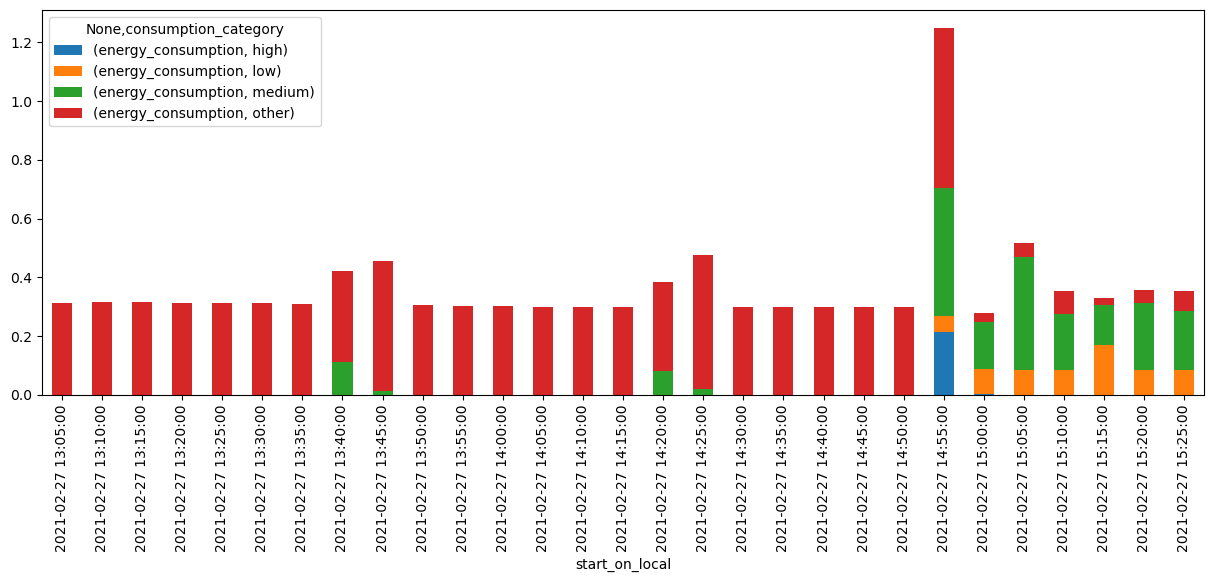

In [85]:
from cycler import cycler
stime='2021-02-27 13:00:00'
etime='2021-02-27 15:30:00'
output.start_on_local=pd.to_datetime(output.start_on_local)
df=output[(output.start_on_local>stime) & (output.start_on_local<etime)]
df['consumption_category']=df['consumption_category'].fillna('actual')
df1=df[df['consumption_category']!='actual']
df2=df[df['consumption_category']=='actual']
df1_pivot=df1.pivot_table(index=['start_on_local','consumption_category'], values='energy_consumption', aggfunc=np.sum)
df_total_actual=df2.pivot_table(index=['start_on_local','consumption_category'], values='energy_consumption', aggfunc=np.sum)
df_total_estimated=df1.pivot_table(index=['start_on_local'], values='energy_consumption', aggfunc=np.sum)
matplotlib.style.use('default')
fig,ax=plt.subplots()
# colors= [ 'red','blue','blue','grey','yellow','black']
# ax.set_prop_cycle(cy)
ax.grid('')
fig.set_size_inches(15,5)
df1_pivot.unstack().plot(kind='bar',ax=ax,stacked=True)

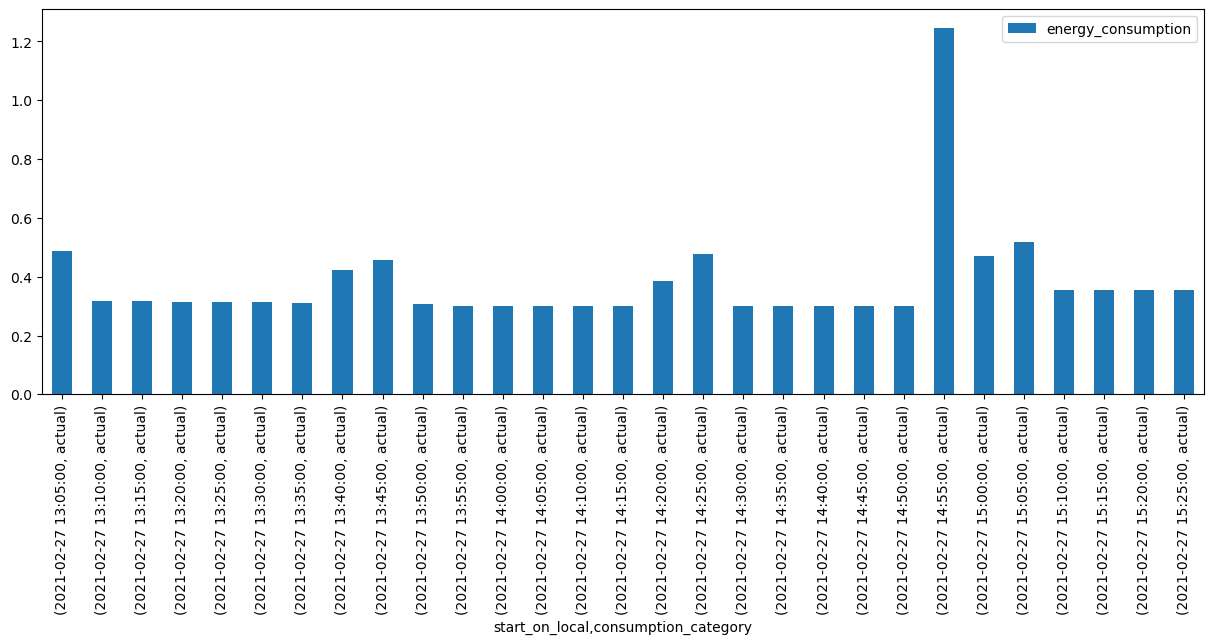

In [66]:
fig,ax=plt.subplots()
ax.grid('')
fig.set_size_inches(15,5)
(df_total_actual).plot(kind='bar',ax=ax,stacked=True)

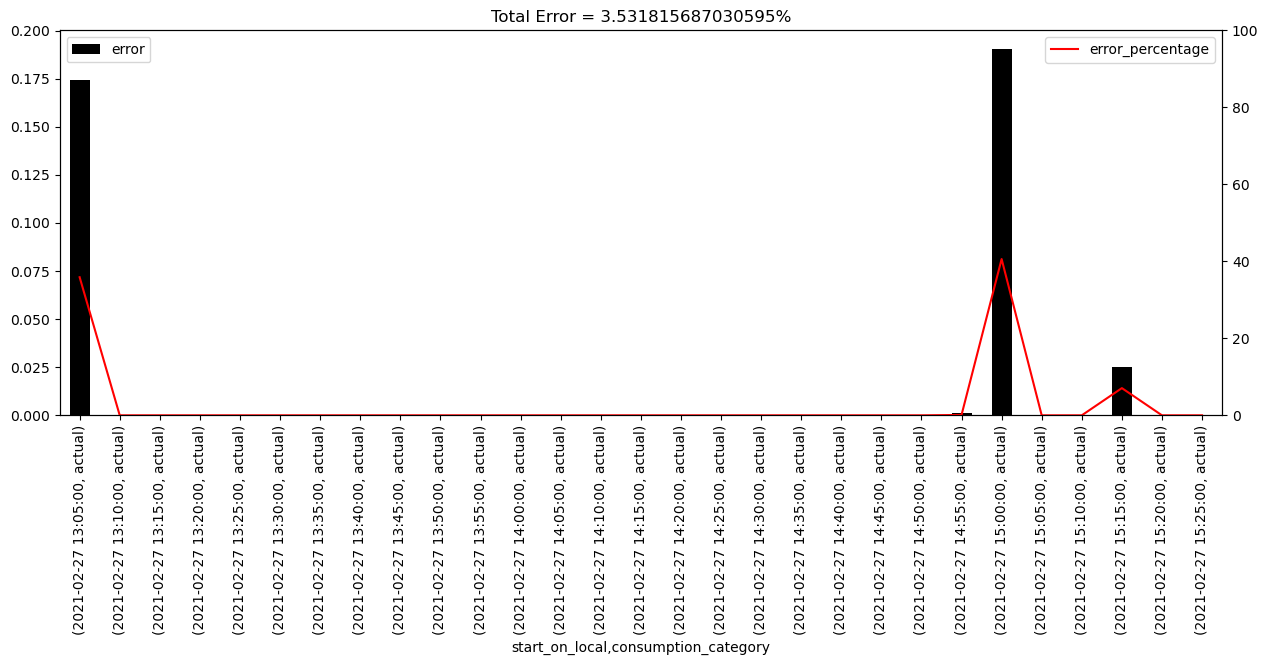

In [67]:
fig,ax=plt.subplots()
ax2=ax.twinx()
ax.grid('')
fig.set_size_inches(15,5)
abs(df_total_actual-df_total_estimated).plot(kind='bar',ax=ax,stacked=True,color='black')
(100*abs(df_total_actual-df_total_estimated)/df_total_actual).plot(ax=ax2,stacked=True,title='Total Error = '+str((100*abs(df_total_actual-df_total_estimated).sum()/df_total_actual.sum()).values[0])+'%', color='red')
# ax.set_ylim(0,0.12)
ax2.set_ylim(0,100)
ax.legend(loc=2, labels=['error'])
ax2.legend(loc=1,labels=['error_percentage'])
# ax.title()

In [68]:
(100*abs(df_total_actual-df_total_estimated)/df_total_actual).mean()[0]

2.884277714635663

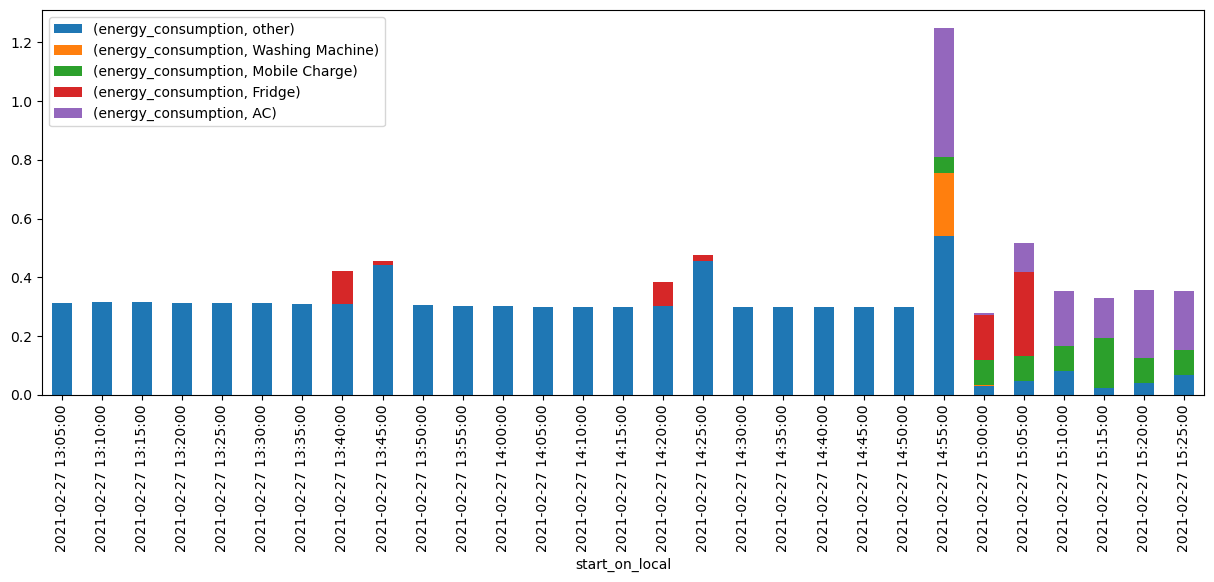

In [69]:
# stime=pd.to_datetime('2021-01-04 09:00:00')
# stime='2021-01-04 00:30:00'
# etime='2021-01-04 23:30:00'
df=output[(output.start_on_local>stime) & (output.start_on_local<etime)]
df['consumption_category']=df['consumption_category'].fillna('actual')
df1=df[df['name']!='all']
df2=df[df['name']=='all']
df1_pivot=df1.pivot_table(index=['start_on_local','type'], values='energy_consumption', aggfunc=np.sum)
df_total_actual=df2.pivot_table(index=['start_on_local','type'], values='energy_consumption', aggfunc=np.sum)
df_total_estimated=df1.pivot_table(index=['start_on_local'], values='energy_consumption', aggfunc=np.sum)
# matplotlib.style.use('seaborn-dark')
fig,ax=plt.subplots()
ax.grid('')
fig.set_size_inches(15,5)
df1_pivot.unstack()[df1_pivot.unstack().columns[::-1]].plot(kind='bar',ax=ax,stacked=True)
ax.legend(loc=2)

# stime=pd.to_datetime('2021-01-04 09:00:00')
# stime= start
# etime=end
# df=output[(output.start_on_local>stime) & (output.start_on_local<etime)]
# df['consumption_category']=df['consumption_category'].fillna('actual')
# df1=df[df['equipment_name']!='all']
# df2=df[df['equipment_name']=='all']
# df1_pivot=df1.pivot_table(index=['start_on_local','equipment_type'], values='energy_consumption', aggfunc=np.sum)
# df_total_actual=df2.pivot_table(index=['start_on_local','equipment_type'], values='energy_consumption', aggfunc=np.sum)
# df_total_estimated=df1.pivot_table(index=['start_on_local'], values='energy_consumption', aggfunc=np.sum)
# # matplotlib.style.use('seaborn-dark')
# fig,ax=plt.subplots()
# ax.grid('')
# fig.set_size_inches(15,5)
# df1_pivot.unstack()[df1_pivot.unstack().columns[::-1]].plot(kind='bar',ax=ax,stacked=True)
# ax.legend(loc=2)

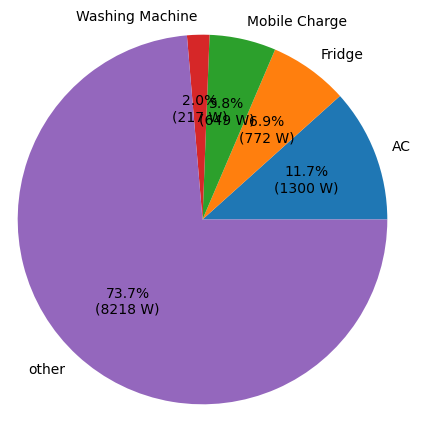

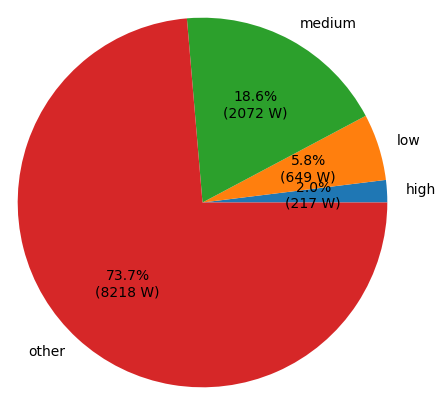

In [70]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} W)".format(pct, absolute)
# stime='2021-01-04 00:30:00'
# etime='2021-01-04 23:30:00'
df=output[(output.start_on_local>=stime) & (output.start_on_local<=etime)]
pivot1=df.pivot_table(index='type', values='energy_consumption', aggfunc=np.sum)
pivot2=df.pivot_table(index='consumption_category', values='energy_consumption', aggfunc=np.sum)
fig,ax =plt.subplots()
fig.set_size_inches(15,5)
# ax.plot(pivot1[pivot1.index!='all'], labels=pivot1[pivot1.index!='all'].index)
ax.pie(pivot1[pivot1.index!='all'], labels=pivot1[pivot1.index!='all'].index, autopct=lambda pct: func(pct, 1000*pivot1[pivot1.index!='all']),radius=1.2)
ax.legend().remove()

fig,ax =plt.subplots()
fig.set_size_inches(15,5)
ax.pie(pivot2[pivot2.index!='all'], labels=pivot2[pivot2.index!='all'].index,autopct=lambda pct: func(pct, 1000*pivot2[pivot2.index!='all']),radius=1.2)
ax.legend().remove()

# def func(pct, allvals):
#     absolute = int(pct/100.*np.sum(allvals))
#     return "{:.1f}%\n({:d} W)".format(pct, absolute)
# stime=start
# etime=end
# df=output[(output.start_on_local>=stime) & (output.start_on_local<=etime)]
# pivot1=df.pivot_table(index='equipment_type', values='energy_consumption', aggfunc=np.sum)
# pivot2=df.pivot_table(index='consumption_category', values='energy_consumption', aggfunc=np.sum)
# fig,ax =plt.subplots()
# fig.set_size_inches(15,5)
# # ax.plot(pivot1[pivot1.index!='all'], labels=pivot1[pivot1.index!='all'].index)
# ax.pie(pivot1[pivot1.index!='all'], labels=pivot1[pivot1.index!='all'].index, autopct=lambda pct: func(pct, 1000*pivot1[pivot1.index!='all']),radius=1.2)
# ax.legend().remove()

# fig,ax =plt.subplots()
# fig.set_size_inches(15,5)
# ax.pie(pivot2[pivot2.index!='all'], labels=pivot2[pivot2.index!='all'].index,autopct=lambda pct: func(pct, 1000*pivot2[pivot2.index!='all']),radius=1.2)
# ax.legend().remove()


In [269]:
# stime=pd.to_datetime('2021-01-04 07:15:10')
# etime=pd.to_datetime('2021-01-04 11:30:59')
# temp_data=sample_df[(sample_df.index>stime) & (sample_df.index<etime)]
# temp_data4=temp[(temp.index>stime) & (temp.index<etime)]

# temp_data2=temp_data[temp_data['observable_event'].isin([1])]
# temp_data3=temp_data[temp_data['observable_event'].isin([2])]
# fig,ax=plt.subplots()
# # ax2=ax.twinx()
# matplotlib.style.use('default')
# fig.set_size_inches(15,5)
# ax.scatter(temp_data2.index,temp_data2.mains_power, color='green', s=15)
# ax.scatter(temp_data3.index,temp_data3.mains_power,color='red', s=15)
# ax.plot(temp_data.index,temp_data.mains_power,color='black', lw=.5)
# # ax.plot(temp_data4.index,temp_data4.mains_power,color='blue', lw=.5)
# # ax.set_ylim(0,.2)
# ax.legend

In [ ]:
def getfeatures(stdate,enddate,onset_data):
    
    sample_data=onset_data[(onset_data['logged_time_local']>=pd.to_datetime(stdate)) & (onset_data['logged_time_local']<=pd.to_datetime(enddate))][['mains_power','logged_time_local']].sort_values('logged_time_local')

    mean_step=2
    factor=10

    ### Processing
    sample_data['before_mean']=sample_data['mains_power'].rolling(mean_step).mean()
#     sample_data['before_max_10']=sample_data['mains_power'].abs().rolling(mean_step*factor).max()
#     sample_data['before_mean_10']=sample_data['mains_power'].abs().rolling(mean_step*factor).mean()
    sample_data['after_mean']=0
#     sample_data['after_mean_10']=0
#     sample_data['after_max_10']=0
    sample_data['per_change']=0
    sample_data['time_spent']=0

    # Features
    per_change=[]
    after_mean=[]
    after_mean_10=[]
    after_max=[]

    for i in range(mean_step,len(sample_data)-mean_step):
        change=100*(sample_data['before_mean'].iloc[i+mean_step]-sample_data['before_mean'].iloc[i-1])/sample_data['before_mean'].iloc[i+mean_step]
        per_change.append(change)
        after_mean.append(sample_data['before_mean'].iloc[i+mean_step])

#     for i in range(mean_step*factor,len(sample_data)-mean_step*factor-3):
#         after_mean_10.append(sample_data['before_mean_10'].iloc[i+3+mean_step*factor])
#         after_max.append(sample_data['before_max_10'].iloc[i+3+mean_step*factor])

    sample_data['per_change'].iloc[mean_step:-mean_step]=per_change
    sample_data['after_mean'].iloc[mean_step:-mean_step]=after_mean
#     sample_data['after_mean_10'].iloc[mean_step*factor:-mean_step*factor-3]=after_mean_10
#     sample_data['after_max_10'].iloc[mean_step*factor:-mean_step*factor-3]=after_max
    sample_data['avg_diff']=sample_data['after_mean']-sample_data['before_mean']
    sample_data['avg_diff']=sample_data['after_mean']-sample_data['before_mean']
    
    #event logic
    sample_data['events']=0
    sample_data.loc[(abs(sample_data['avg_diff'])>.015) & (sample_data['mains_power']<.10), 'events']=1
    sample_data.loc[(abs(sample_data['per_change'])>10) & (sample_data['mains_power']>.10), 'events']=1
#     sample_data=sample_data
    sample_data['event_type']=0

    #### transition start=1, transition= 2, transition end=3, steady=0
    sample_data.loc[sample_data['events']==True,'event_type']=2
    sample_data.loc[sample_data['events']==False,'event_type']=0
    
    #### map transition states
    sample_data['event_effect']=0
    prev_state=0
    event_mean_before=0
    for i in range(1,len(sample_data)):
        if sample_data['events'].iloc[i]==0:
            if prev_state==1:
                sample_data['event_type'].iloc[i-1]=3
            prev_state=0
        else:
            if prev_state==0:
                sample_data['event_type'].iloc[i]=1
            prev_state=1
    
    
    #### Observable events for on/off activity
    sample_data['observable_event']=0
#     sample_data.loc[sample_data['event_type']==1,'event_effect']=sample_data.loc[sample_data['event_type']==1,'after_mean_10']-sample_data.loc[sample_data['event_type']==1,'before_mean_10']
#     sample_data.loc[sample_data['event_type']==1,'event_effect_peak']=sample_data.loc[sample_data['event_type']==1,'after_max_10']-sample_data.loc[sample_data['event_type']==1,'before_max_10']
    sample_data['event_effect']=0
    for i in range(len(sample_data)):
        if sample_data['event_type'].iloc[i]==1:
            after=0
            j=i+5
            for j in range(i+5,min(i+5+mean_step*factor,len(sample_data)-1)):
                if (sample_data['event_type'].iloc[j] != 1):
                    after=after +   sample_data['mains_power'].iloc[j]
                else:
                    break
            after=after/(j-(i+4))
            before=0
            k=i-3
            for k in range(i-3,max(i-3-mean_step*factor,0),-1):
                if (sample_data['event_type'].iloc[k] != 1):
                    before=before +   sample_data['mains_power'].iloc[k]
                else:
                    break
            before=before/(i-(k+2))
            sample_data['event_effect'].iloc[i]=after-before
    
    
    sample_data.loc[(abs(sample_data['event_effect'])>.010),'observable_event']=1
    sample_data.loc[(sample_data['event_effect']<0) & (sample_data['observable_event']==1),'observable_event']=2
    return sample_data


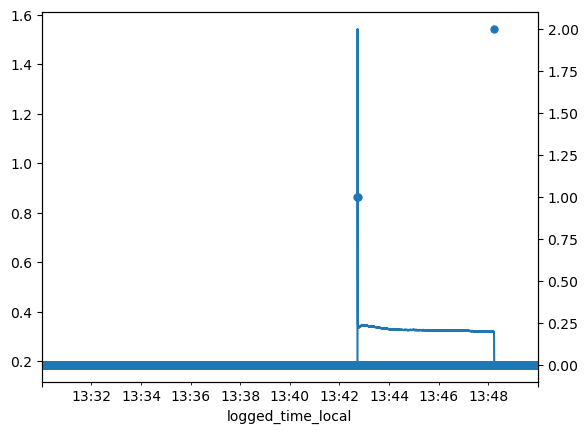

In [21]:
fig,ax= plt.subplots()
ax2=ax.twinx()
start_time=pd.to_datetime('2021-2-27 13:30:00')
end_time= pd.to_datetime('2021-2-27 13:50:00')
sample_data[sample_data.logged_time_local>start_time][sample_data.logged_time_local<end_time].set_index('logged_time_local')['mains_power'].plot(ax=ax)
sample_data[sample_data.logged_time_local>start_time][sample_data.logged_time_local<end_time].set_index('logged_time_local')['observable_event'].plot(ax=ax2, lw=0, marker='o', ms=5)


In [86]:
pd.concat([sample_data.mains_power.shift(i) for i in range(10)], 1).fillna(0).values.tolist()

[[0.21600000000000003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.21617000000000003,
  0.21600000000000003,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.21584,
  0.21617000000000003,
  0.21600000000000003,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.21572,
  0.21584,
  0.21617000000000003,
  0.21600000000000003,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.21609999999999996,
  0.21572,
  0.21584,
  0.21617000000000003,
  0.21600000000000003,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.2162,
  0.21609999999999996,
  0.21572,
  0.21584,
  0.21617000000000003,
  0.21600000000000003,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.21565,
  0.2162,
  0.21609999999999996,
  0.21572,
  0.21584,
  0.21617000000000003,
  0.21600000000000003,
  0.0,
  0.0,
  0.0],
 [0.21559999999999999,
  0.21565,
  0.2162,
  0.21609999999999996,
  0.21572,
  0.21584,
  0.21617000000000003,
  0.21600000000000003,
  0.0,
  0.0],
 [0.21578,
  0.21559999999999999,
  0.21565,
  0.2162,
  0.2160999999